# **What game should i design?**
> 코드스테이츠 AI 부트캠프 Section 1 프로젝트<br>
: **다음 분기에 어떤 게임을 설계해야하는가?**


- **프로젝트 진행 기간** : 2021.05.31 ~ 2021.06.03

- **문제** : 다음 분기에 어떤 게임을 설계해야하는가?


- **해결 과정** : 문제 해결을 위해 기존 게임 출고량 데이터에 기반하여 인사이트를 얻고, 의사 결정 내리기


- **발표 대상** : 데이터 분석에 관한 배경지식이 없는 비데이터 직군


- **분석 내용**
  1. 지역에 따라서 선호하는 게임 장르가 다를까?
  2. 연도별 게임의 트렌드가 있을까?
  3. 출고량이 높은 게임에 대한 분석 및 시각화 프로세스

 


# **Data Description**
- **Data Type** :  비디오 게임 출고량 데이터
- **Features**

  1) `Name` : 게임의 이름

  2) `Platform` : 게임이 지원되는 플랫폼의 이름 (ex. wii, psp, ...)

  3) `Year` : 게임이 출시된 연도

  4) `Genre` : 게임의 장르

  5) `Publisher` : 게임을 제작한 회사

  6) `NA_Sales` : 북미지역에서의 출고량 (단위 : 백만)

  7) `EU_Sales` : 유럽지역에서의 출고량 (단위 : 백만)

  8) `JP_Sales` : 일본지역에서의 출고량 (단위 : 백만)

  9) `Other_Sales` : 기타지역에서의 출고량 (단위 : 백만)

  * *Sales feature : k = 1000(천), m = 1000000(백만)*

# **1. 데이터 준비**


In [ ]:
# 그래프 한글 폰트 깨짐 방지를 위한 글꼴 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# 결측치 시각적 확인 
import missingno as msno

# 카이제곱검증
from scipy import stats

##**1-1. 데이터 준비 및 확인**

In [ ]:
# csv형식 데이터 불러오기
df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv').iloc[:,1:] # 데이터를 불러올 때 0번 인덱스의 컬럼인 [Unnamed: 0]를 제외하고 1번 컬럼부터 가져오기
df.head(20)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04
5,Power Pro Kun Pocket 8,DS,2005.0,Sports,Konami Digital Entertainment,0,0,0.14,0
6,JASF: Jane's Advanced Strike Fighters,PC,2011.0,Simulation,Deep Silver,0.02,0.01,0,0
7,Samurai Warriors: State of War,PSP,2005.0,Action,Tecmo Koei,0.07,0,0.11,0.01
8,Imabikisou,PS3,2007.0,Adventure,Sega,0,0,0.04,0
9,The Penguins of Madagascar: Dr. Blowhole Retur...,PS3,2011.0,Action,THQ,0.04,0.03,0,0.01


In [ ]:
# 데이터 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16598 non-null  object 
 1   Platform     16598 non-null  object 
 2   Year         16327 non-null  float64
 3   Genre        16548 non-null  object 
 4   Publisher    16540 non-null  object 
 5   NA_Sales     16598 non-null  object 
 6   EU_Sales     16598 non-null  object 
 7   JP_Sales     16598 non-null  object 
 8   Other_Sales  16598 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.1+ MB


In [ ]:
# 범주형 컬럼의 unique 값 확인

print('---플랫폼 : 총', len(df.Platform.unique()),'개---')
print(df.Platform.unique())


print('\n---게임 장르 : 총', len(df.Genre.unique()),'개---')
print(df.Genre.unique())

print('\n---게임 이름 : 총', len(df.Name.unique()),'개---')
print(df.Name.unique())

---플랫폼 : 총 31 개---
['DS' 'Wii' 'PSP' 'PS3' 'PC' 'PS' 'GBA' 'PS4' 'PS2' 'XB' 'X360' 'GC' '3DS'
 '2600' 'SAT' 'GB' 'NES' 'DC' 'N64' 'XOne' 'SNES' 'WiiU' 'PSV' 'GEN' 'SCD'
 'WS' 'NG' 'TG16' '3DO' 'GG' 'PCFX']

---게임 장르 : 총 13 개---
['Action' 'Adventure' 'Misc' 'Platform' 'Sports' 'Simulation' 'Racing'
 'Role-Playing' 'Puzzle' 'Strategy' 'Fighting' 'Shooter' nan]

---게임 이름 : 총 11493 개---
["Candace Kane's Candy Factory" 'The Munchables'
 'Otome wa Oanesama Boku ni Koi Shiteru Portable' ...
 'White Album: Tsuzurareru Fuyu no Omoide' 'Minna no Chizu 2'
 'Rainbow Islands: Revolution']


##**1-2. 데이터 전처리**

###**1-2-1. `NA_Sales`,	`EU_Sales`,	`JP_Sales`,	`Other_Sales` - 데이터 타입 변환**
  ```
  (1) 기존 데이터 object 타입 → 출고량(수치) 데이터로서 int 타입으로 변환
  (2) 소수와 k,m 등 단위 통일 (k = 천 , m = 백만)
  (3) Global_Sales 컬럼 생성 (Sales 컬럼들의 총 합)
  ```

In [ ]:
# NA_Sales, EU_Sales, JP_Sales, Other_Sale → K, M 단위 통일 (https://stackoverflow.com/questions/39684548/convert-the-string-2-90k-to-2900-or-5-2m-to-5200000-in-pandas-dataframe)

# value_to_float() : K, M을 수치로 변환 및 각 국가 출고량 데이터 float 타입으로 변환
def value_to_float(x):
    if type(x) == float or type(x) == int:
        return x
    if 'K' in x:
        if len(x) > 1:
            return float(x.replace('K', '')) * 1000 / 1000000
        return 1000.0 / 1000000
    if 'M' in x:
        if len(x) > 1:
            return float(x.replace('M', '')) * 1000000 /1000000
        return 1000000.0  / 1000000
    elif type(x) == str:
      return float(x)

# 데이터에 적용
df['NA_Sales'] = df['NA_Sales'].apply(value_to_float)
df['EU_Sales'] = df['EU_Sales'].apply(value_to_float)
df['JP_Sales'] = df['JP_Sales'].apply(value_to_float)
df['Other_Sales'] = df['Other_Sales'].apply(value_to_float)

In [ ]:
# 전체 출고량 컬럼 생성 (Global_Sales)
df['Global_Sales'] = df['NA_Sales']+df['EU_Sales']+df['JP_Sales']+df['Other_Sales']

###**1-2-2. `Year` - 데이터 타입 변환 및 결측치 처리**
  ```
  (1) N/A , 2015(4자리 연도), 15(2자리 연도), 0(한자리 연도) 값이 섞여있다.
      → 4자리로 통일
  (2) 그 이후, 출고량 확인하고 결측치 처리 단계로 넘어가기
      → 미미한 출고량을 가진 Year 결측값 행은 삭제 / 높은 출고량 가진 Year 결측값 행은 수기로 채우기
  (3) 결측치 처리
      - Year 컬럼의 결측값 중 Total_Sales를 기준으로 출고량 top10을 가려내 수기로 채워준다.
      - 나머지 결측값을 가진 행은 데이터 삭제
  ```

In [ ]:
# 1자리 년도, 2자리 년도 → 4자리 연도로 통일 후 year_list에 담아주기
year_list = []

for i in df.Year:
  if i >= 0 and i < 10:
    i = str(i)
    i = '200'+i
    i = float(i)
        
  elif i >= 10 and i < 20:
    i = str(i)
    i = '20'+i
    i = float(i)
    
  elif i > 85 and i < 99:
    i = str(i)
    i = '19'+i
    i = float(i)
    
  year_list.append(i)
print(year_list)

[2008.0, 2009.0, 2010.0, 2010.0, 2010.0, 2005.0, 2011.0, 2005.0, 2007.0, 2011.0, 2001.0, 2003.0, 2008.0, 2005.0, 2006.0, 2009.0, 2003.0, 2014.0, 2015.0, 2009.0, 2002.0, 1997.0, 2005.0, 2014.0, 2013.0, 2002.0, 1996.0, 2011.0, 2004.0, 2000.0, 2011.0, nan, 2006.0, 2015.0, 2004.0, 2009.0, 2005.0, 1984.0, 2008.0, 2006.0, 2000.0, 2004.0, 2007.0, 2008.0, 2013.0, 2015.0, 1998.0, 2002.0, 2008.0, 2009.0, 2005.0, 2009.0, 2001.0, 2009.0, 2009.0, 2010.0, 2016.0, 2010.0, 2010.0, 1985.0, 2006.0, 2008.0, 2010.0, 2011.0, 2004.0, 1998.0, 2011.0, 2004.0, 2014.0, 2010.0, 1999.0, 2007.0, 2015.0, 2003.0, 2009.0, 2010.0, 1985.0, 2000.0, 2007.0, 2008.0, 2005.0, 1997.0, 1997.0, 2003.0, 2000.0, 2003.0, 1995.0, 2005.0, 2010.0, 1999.0, 2010.0, 2005.0, 2011.0, 2014.0, 2003.0, 1998.0, 2011.0, 2001.0, 2010.0, 1993.0, 2014.0, 2009.0, 2002.0, 2004.0, 2005.0, 2007.0, 2005.0, 2000.0, 2016.0, nan, 2012.0, 2007.0, 1996.0, 2005.0, 2006.0, 2014.0, 2008.0, 2016.0, 2004.0, 2006.0, 2007.0, 1999.0, 2007.0, 2003.0, 2012.0, 2009.

In [ ]:
# year_list를 Year 컬럼 값으로 할당
df.Year = year_list
df.Year

0        2008.0
1        2009.0
2        2010.0
3        2010.0
4        2010.0
          ...  
16593    2006.0
16594    2005.0
16595    2015.0
16596    2013.0
16597    1996.0
Name: Year, Length: 16598, dtype: float64

In [ ]:
# Year 컬럼의 결측값 행 불러와 Total_Sales 기준 top10 뽑기

condition = df['Year'].isnull()
sales_top10_inull = df[condition].sort_values(by="Global_Sales",ascending=False).head(10)
sales_top10_inull

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
6949,Madden NFL 2004,PS2,NaN,Sports,Electronic Arts,4.26,0.26,0.01,0.71,5.24
10965,FIFA Soccer 2004,PS2,NaN,Sports,Electronic Arts,0.59,2.36,0.04,0.51,3.50
3347,LEGO Batman: The Videogame,Wii,NaN,Action,Warner Bros. Interactive Entertainment,1.86,1.02,0.00,0.29,3.17
3562,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,NaN,1.57,1.02,0.00,0.41,3.00
16275,Space Invaders,2600,NaN,Shooter,Atari,2.36,0.14,0.00,0.03,2.53
31,Rock Band,X360,NaN,Misc,Electronic Arts,1.93,0.34,0.00,0.21,2.48
13327,Frogger's Adventures: Temple of the Frog,GBA,NaN,Adventure,Konami Digital Entertainment,2.15,0.18,0.00,0.07,2.40
8529,LEGO Indiana Jones: The Original Adventures,Wii,NaN,Action,LucasArts,1.54,0.63,0.00,0.22,2.39
2130,Call of Duty 3,Wii,NaN,Shooter,Activision,1.19,0.84,0.00,0.23,2.26
4181,Rock Band,Wii,NaN,Misc,MTV Games,1.35,0.56,0.00,0.20,2.11


In [ ]:
# Total_sales(전체 게임 출고량) top10안에 드는 Year 컬럼의 결측값은 수기로 채워주기

df.loc[6949, 'Year'] = 2003
df.loc[10965, 'Year']= 2003
df.loc[3347, 'Year'] = 2008
df.loc[3562, 'Year'] = 2005
df.loc[16275, 'Year'] = 1978
df.loc[31, 'Year'] = 2007
df.loc[13327, 'Year'] = 2001
df.loc[8529, 'Year'] = 2008
df.loc[2130, 'Year'] = 2006
df.loc[4181, 'Year']= 2007


In [ ]:
# 채워주고 남은 결측값은 dropna 
df.dropna(axis = 0, inplace = True)

In [ ]:
# float 타입인 4자리 년도(가 담긴 column의 값들)를 int 타입으로 만들기
df.Year = df.Year.apply(int)
df.Year

0        2008
1        2009
2        2010
3        2010
4        2010
         ... 
16593    2006
16594    2005
16595    2015
16596    2013
16597    1996
Name: Year, Length: 16250, dtype: int64

In [ ]:
# Year 컬럼의 unique 값 
print('---게임 출시 연도 : 총', len(df.Year.unique()), '개---')
print(df.Year.sort_values().unique())

---게임 출시 연도 : 총 40 개---
[1978 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992
 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006
 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2020]


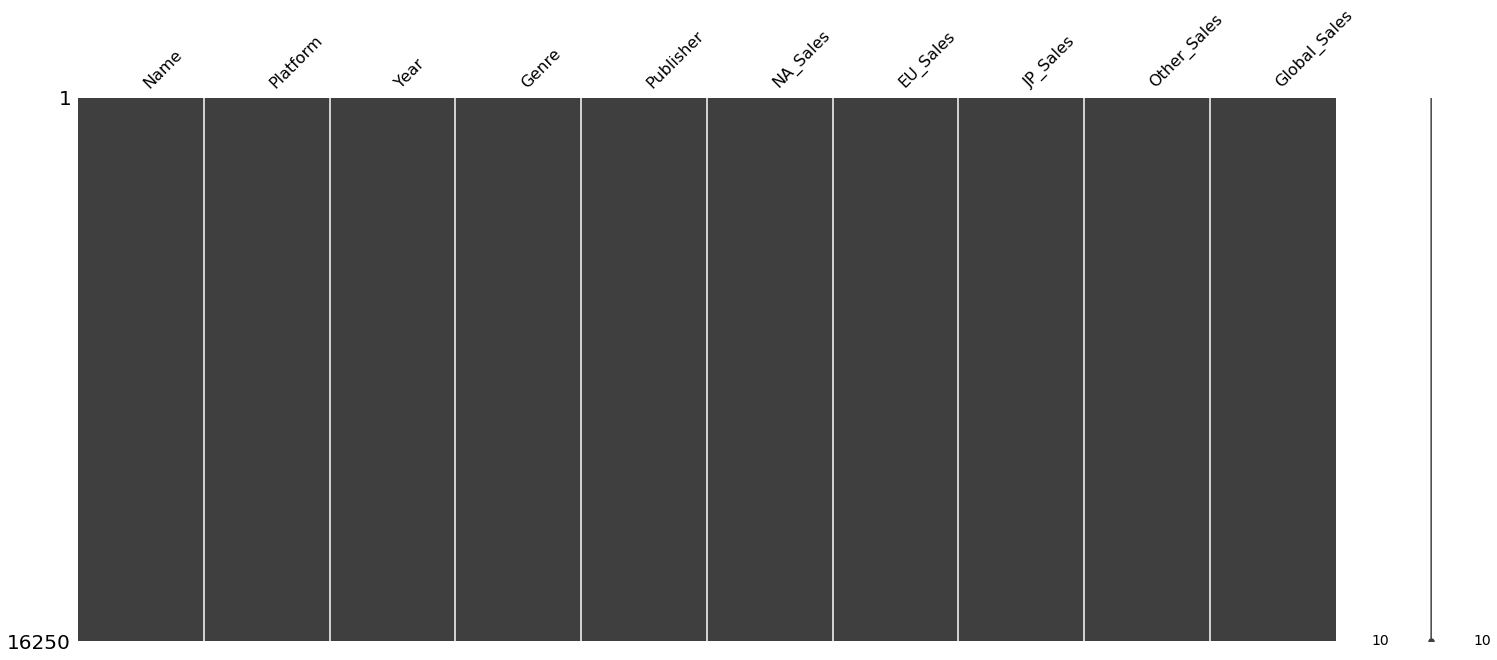

In [ ]:
 # 전 컬럼 결측치처리 잘 되었나 시각적 확인

msno.matrix(df);

# **2. 탐색적 데이터 분석 (EDA)**
- 지역에 따라서 선호하는 게임 장르가 다를까 → **지역별 게임 장르 출고량**확인
- 연도별 게임의 트렌드가 있을까 → **연도별 게임 장르/플랫폼/게임 제작회사/지역별 출고량** 확인
- **출고량이 높은 게임**에 대한 분석 및 시각화 프로세스


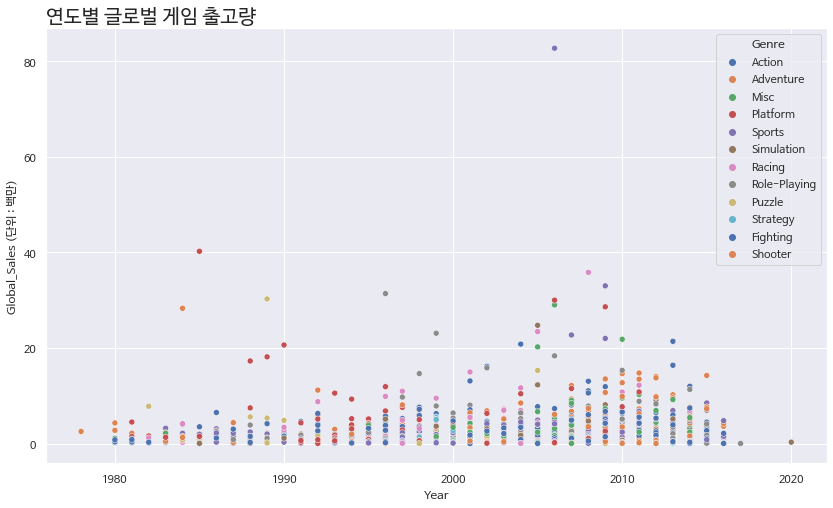

In [ ]:
# 대략적인 분포 확인 - 각 연도에서 특히 높은 글로벌 출고량을 기록한 게임들이 존재한다. (ex. 2006년의 sports 장르 게임)

plt.figure(figsize=(14,8))
p = sns.scatterplot(x = df['Year'], y = df['Global_Sales'], hue=df['Genre'], palette='deep')

plt.rc("font", family="NanumBarunGothic")
sns.set(font="NanumBarunGothic", rc={"axes.unicode_minus":False})

p.set_ylabel('Global_Sales (단위 : 백만)', fontsize = 12)
p.set_xlabel('Year', fontsize = 12)
p.set_title('연도별 글로벌 게임 출고량', loc='left', fontsize=20);

##**2-1. 지역별 게임 장르 출고량 확인**

###**2-1-1.장르별 글로벌 게임 출고량 확인**

In [ ]:
global_genre_sum = df.groupby(['Genre'])['Global_Sales'].sum()
na_genre_sum = df.groupby(['Genre'])['NA_Sales'].sum() 
eu_genre_sum = df.groupby(['Genre'])['EU_Sales'].sum() 
jp_genre_sum = df.groupby(['Genre'])['JP_Sales'].sum() 
other_genre_sum = df.groupby(['Genre'])['Other_Sales'].sum() 

In [ ]:
# 오름차순 barplot을 만들기 위해 미리 데이터 오름차순 정렬해놓기
global_sort = global_genre_sum.to_frame().sort_values(by='Global_Sales')

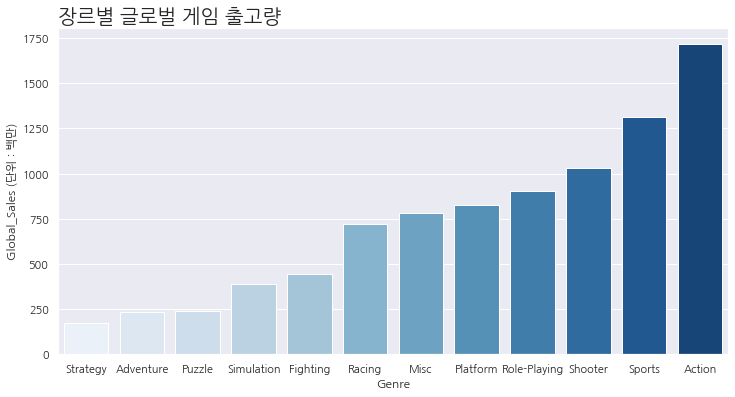

In [ ]:
# 게임 장르 글로벌 트랜드

plt.figure(figsize=(12,6))
p = sns.barplot(data = global_sort, x = global_sort.index, y = 'Global_Sales', palette='Blues');

sns.set(font="NanumBarunGothic", rc={"axes.unicode_minus":False}, style='darkgrid')

p.set_ylabel('Global_Sales (단위 : 백만)', fontsize = 12)
p.set_xlabel('Genre', fontsize = 12)

p.set_title('장르별 글로벌 게임 출고량', loc='left', fontsize=20);

###**2-1-2.장르별 국가별 게임 출고량 확인**

In [ ]:
# 장르를 기준으로 각 국가별 게임 출고량 데이터 합 구하기 
# 국가별로 어떤 장르의 게임이 가장 많이 팔렸는지 확인

genre_sum = df.groupby(['Genre'])[["NA_Sales","EU_Sales","JP_Sales","Other_Sales"]].sum()
genre_sum

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Genre,,,,
Action,862.15,515.29,156.60,184.50
Adventure,103.94,63.84,51.87,16.77
Fighting,220.35,99.90,87.14,36.15
Misc,398.01,209.05,104.18,73.05
Platform,445.38,200.63,130.53,51.45
Puzzle,121.58,50.47,56.24,12.44
Racing,354.70,235.02,56.32,76.51
Role-Playing,318.76,183.09,342.93,56.73
Shooter,578.03,311.21,38.18,102.12


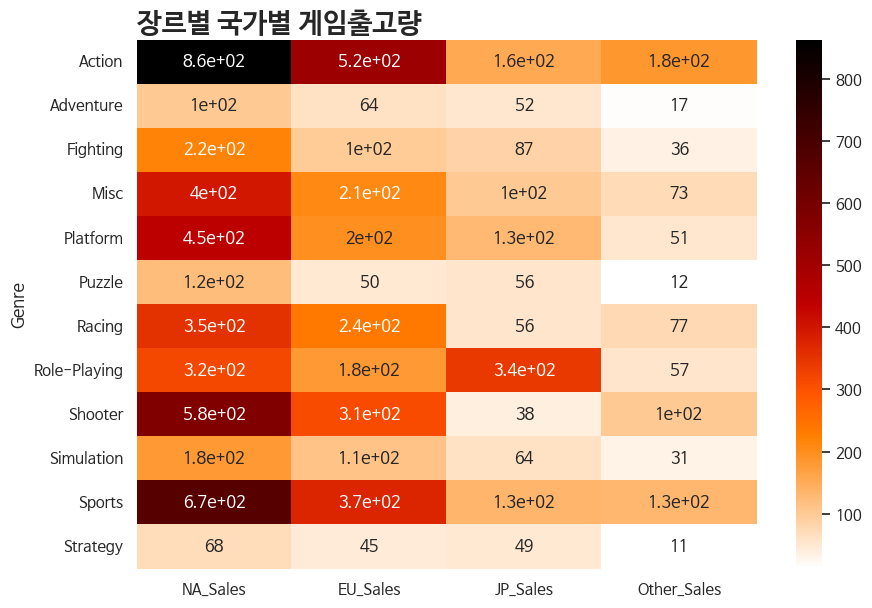

In [ ]:
# genre_sum 히트맵 시각화

plt.figure(figsize = (10,7), dpi=100)

sns.heatmap(genre_sum, cmap='gist_heat_r', edgecolors='white', annot=True)

plt.title('장르별 국가별 게임출고량',fontsize=20, fontweight='bold', loc= 'left');

###**2-1-3. 지역에 따라 발매된 게임 장르는 차이가 있을까?**
- **Two sample 카이제곱 검정**<br>
  두 표본집단의 분포가 동일한지 확인할 때 사용한다. 이를 통해 두 표본 집단이 연관이 있는지 검증한다.<br>
   카이제곱검정은 범주형 데이터에만 사용할 수 있다.<br> 
   ⇛ 따라서 **지역별로 출고된 게임의 장르를 카운트**하여 **지역에 따라 발매된 게임 장르에 차이가 존재하는지 확인**할 것이다.

- **영가설(H0)**<br> 
지역에 따라 발매된 게임 장르에는 차이가 없다.(기각을 위한 가설)
- **대안가설(HA)** <br>
지역에 따라 발매된 게임 장르에는 차이가 있다.(주장하고자 하는 바)





In [ ]:
# Non Zero count Chi Square Test
# 판매량이 0인 지역은 '발매되지 않았다' 가정하고 진행
# 지역에 따른 발매 게임 장르의 차이

stacked = np.array([[0, 0, 0, 0]])

for i in df.Genre.dropna().unique():
    stack = np.count_nonzero(df[df['Genre'] == i].loc[:, 'NA_Sales':'Other_Sales'], axis=0)
    stacked = np.concatenate((stacked, stack.reshape(1, 4)), axis=0)

    
stacked = pd.DataFrame(stacked)
stacked.drop(index= [0], inplace=True) # 맨 처음 설정해놓은 np.array([[0, 0, 0, 0]])
stacked.index = df.Genre.dropna().unique()
stacked.columns=['NA', 'EU', 'JP', 'Other']

In [ ]:
stacked

,NA,EU,JP,Other
Action,2518,2404,1152,2112
Adventure,537,488,736,447
Misc,1161,923,530,1006
Platform,790,719,274,601
Sports,1814,1542,595,1554
Simulation,604,500,266,540
Racing,1082,1001,226,841
Role-Playing,848,765,1036,795
Puzzle,435,298,153,297
Strategy,333,406,267,333


In [ ]:
# 결과: chi square statistic / p-value / degree of freedom

print(stats.chi2_contingency(stacked)[:3])
print('\n===========================\n')
print("p-value가 0.05 미만이므로, 영가설을 기각하고 대안가설을 채택한다. \n즉,지역에 따라 발매된 게임 장르에는 차이가 있다.")

(1617.42021742614, 0.0, 33)


p-value가 0.05 미만이므로, 영가설을 기각하고 대안가설을 채택한다. 
즉,지역에 따라 발매된 게임 장르에는 차이가 있다.


###**2-1-4.장르별 글로벌 + 지역별 게임 출고량 확인**
- 카이제곱검정 결과를 토대로 **지역에 따라 발매된 게임 장르의 출고량**에는 어떤 차이가 존재하는지 확인해보자.

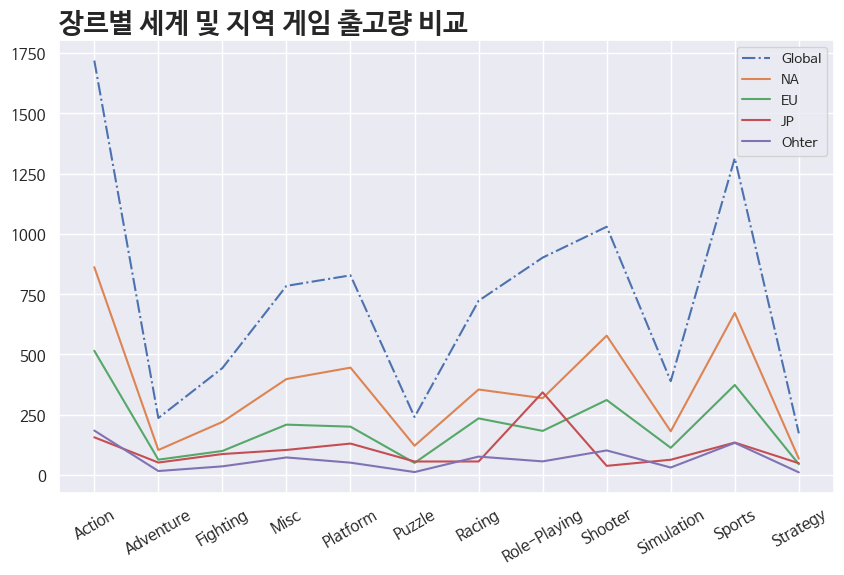

In [ ]:
# 장르별 지역 및 글로벌 게임 출고량 비교 


fig, ax = plt.subplots(1,1,figsize=(10,6), dpi=100)

ax.plot(global_genre_sum.index, global_genre_sum, label='Global', linestyle='-.')
ax.plot(na_genre_sum.index, na_genre_sum, label='NA')
ax.plot(eu_genre_sum.index, eu_genre_sum, label='EU')
ax.plot(jp_genre_sum.index, jp_genre_sum, label='JP')
ax.plot(other_genre_sum.index, other_genre_sum, label='Ohter')


ax.set_title('장르별 세계 및 지역 게임 출고량 비교',fontsize=20, fontweight='bold', loc= 'left')
ax.legend(fontsize = 10, loc = 'upper right')
ax.tick_params(axis = 'x', labelrotation =30)
plt.show();



### **2-1-5. 지역별 게임 장르 출고량 인사이트 정리**

1978년부터 2020년까지 출고된 게임 출고량 데이터를 확인한 결과,
  - `글로벌 게임 출고량 기준`, Action / sport / shooter / platform 순으로 출고량이 많았다.<br>
     ⇛ 특히, `북미(NA)`와 `유럽(EU)` 대륙의 장르별 게임 출고량은 `장르별 글로벌 게임 출고량`이 비슷한 경향을 보였다. (순위 및 증감)


  - `장르별 게임 출고량`은 대부분 모든 대륙에서 순위가 비슷한 경향을 보였다.<br>
    ⇛ 일본 시장(JP)에서 `Role-Playing` 장르의 게임 출고량이 유독 강세를 보인 다는 것이 특이점


##**2-2. 연도별 게임 트랜드 확인**

###**2-2-1. 연도별 세계 게임 출고량 확인**

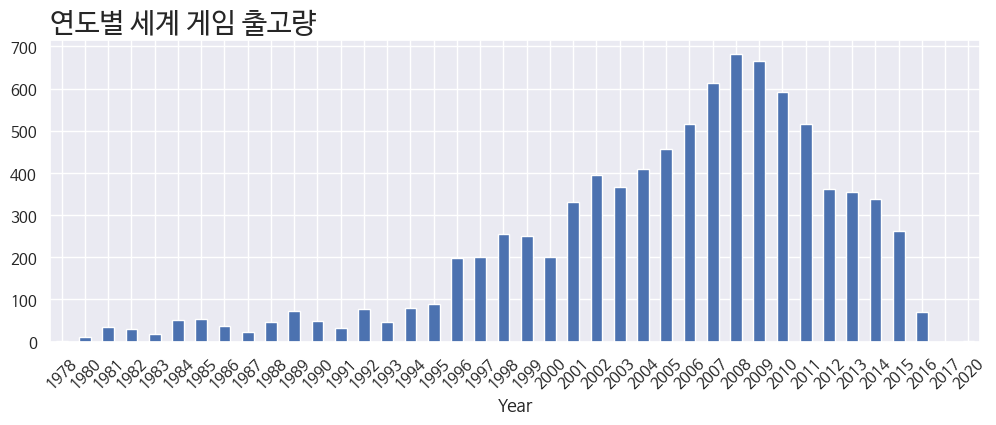

In [ ]:
# 연도별 총 게임 출고량 확인
plt.figure(figsize=(12,4), dpi = 100)

p = df.groupby(['Year'])["Global_Sales"].sum().plot.bar()
p.tick_params(axis = 'x', labelrotation =45)
p.set_title('연도별 세계 게임 출고량', loc='left', fontsize=20);

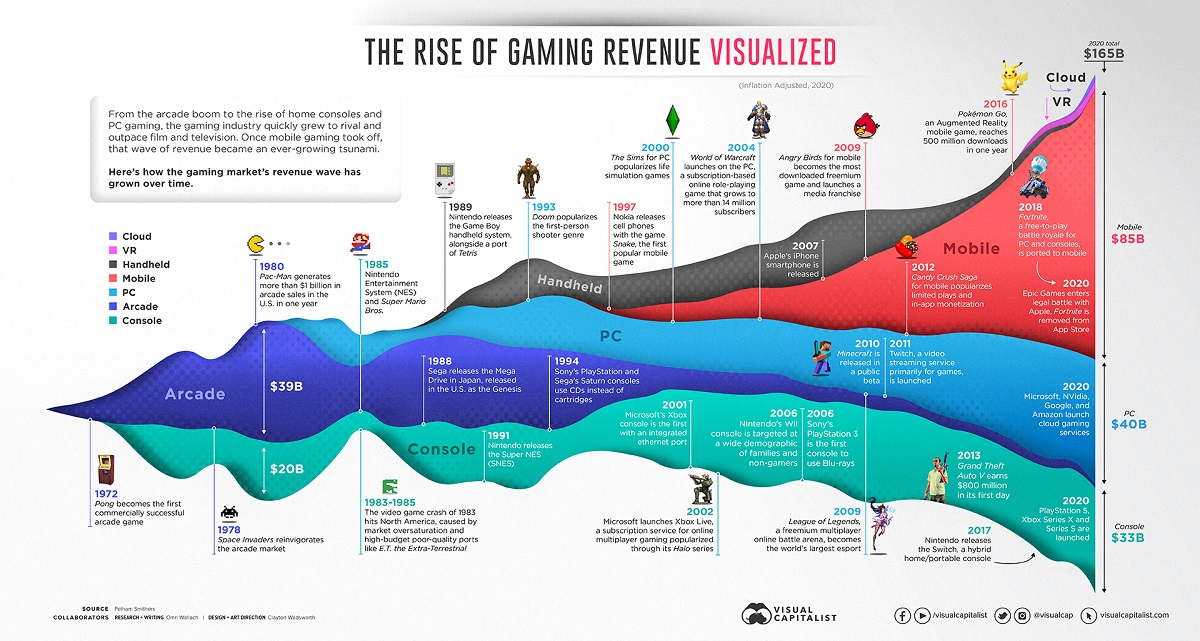

- 비디오 게임 출고량은 2008년 최고 상승세를 찍고, 현재까지 꾸준히 하락세 보이고 있다.<br>
  **⇛ 모바일 게임의 등장으로 비디오 게임 자체에 대한 선호도 하락세**
  [(이미지 출처)](https://www.visualcapitalist.com/50-years-gaming-history-revenue-stream/)



###**2-2-2. 연도별 게임 장르 출고량 확인**

In [ ]:
# 연도별 게임 장르 출고량 분석
year_gen_trend = df[["Year","Genre","Global_Sales"]].groupby(["Year","Genre"]).sum()
year_gen_trend.sort_values('Year',ascending=True)

Global_Sales
Year Genre                     
1978 Shooter               2.53
1980 Action                0.34
     Fighting              0.77
     Misc                  2.70
     Shooter               7.07
...                         ...
2016 Action               19.84
     Racing                1.67
2017 Role-Playing          0.04
     Action                0.01
2020 Simulation            0.29

[389 rows x 1 columns]

Text(0.5, 0, 'Year')

<Figure size 1200x400 with 0 Axes>

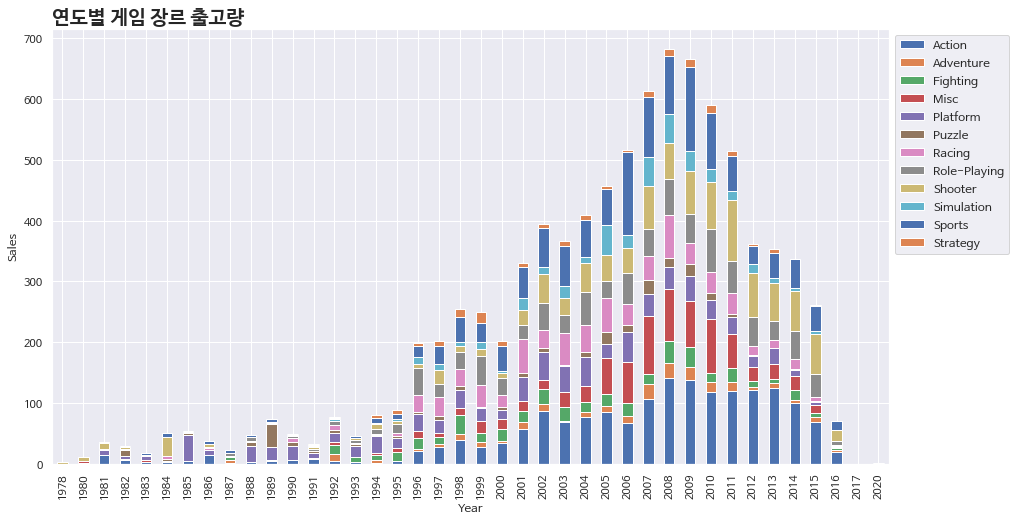

In [ ]:
# multi index 사용 시 stack/ unstack 사용

plt.figure(figsize=(12,4), dpi = 100)

ax = year_gen_trend['Global_Sales'].unstack().plot.bar(stacked=True, figsize=(15,8));
ax.set_title('연도별 게임 장르 출고량',fontsize=20, fontweight='bold', loc= 'left')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='medium')

ax.set_ylabel('Sales')
ax.set_xlabel('Year')


###**2-2-3. 연도별 장르 출고량 확인 (2000년대 이후)**


In [ ]:
df_2000 = df[df['Year']>= 2000]
df_2000_genre = df_2000[['Year','Genre','Global_Sales']]

Text(0.0, 1.0, '2000년대 이후 연도별 게임 장르 출고량(%)')

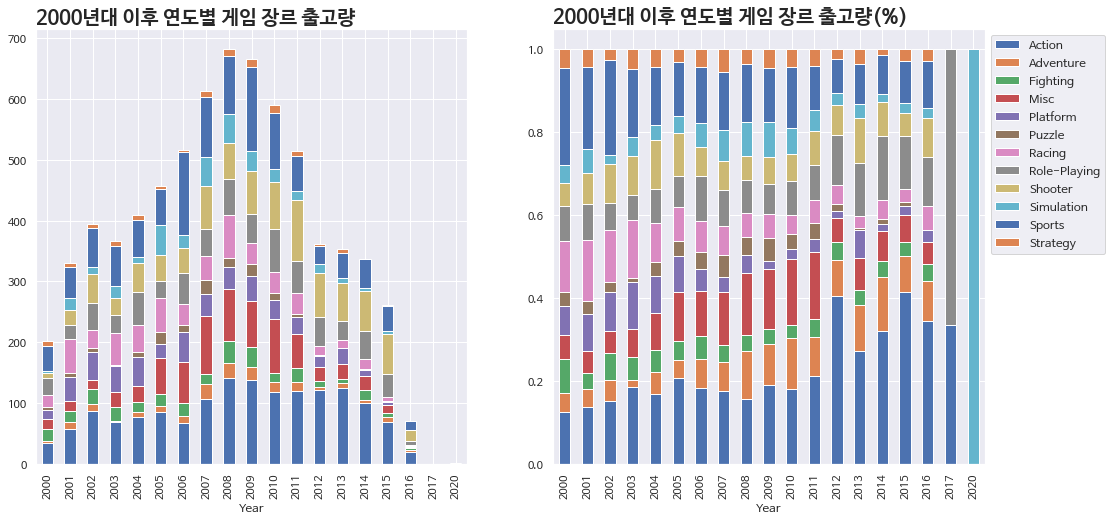

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 8))

isDefault_by_purpose = df_2000_genre.groupby(['Year','Genre']).sum()
isDefault_by_purpose['Global_Sales'].unstack().plot.bar(stacked=True, ax=ax1)
ax1.get_legend().remove()
ax1.set_title("2000년대 이후 연도별 게임 장르 출고량",fontsize=20, fontweight='bold', loc= 'left')

label_crosstab_purpose = pd.crosstab(df_2000_genre['Year'], df_2000_genre['Genre']).apply(lambda x: x/x.sum(), axis=1)
label_crosstab_purpose.plot(kind='bar', stacked=True, ax=ax2)
ax2.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='medium');
ax2.set_title("2000년대 이후 연도별 게임 장르 출고량(%)",fontsize=20, fontweight='bold', loc= 'left')

###**2-2-4. 연도별 플랫폼 출고량 확인**

In [ ]:
# 연도별 게임 플랫폼 출고량 분석
year_plat_trend = df[["Year","Platform","Global_Sales"]].groupby(["Year","Platform"]).sum()
year_plat_trend.sort_values('Year',ascending=True)

Global_Sales
Year Platform              
1978 2600              2.53
1980 2600             10.88
1981 2600             35.68
1982 2600             28.88
1983 2600              5.84
...                     ...
2016 X360              0.83
     XOne             12.38
2017 PSV               0.02
     PS4               0.03
2020 DS                0.29

[242 rows x 1 columns]

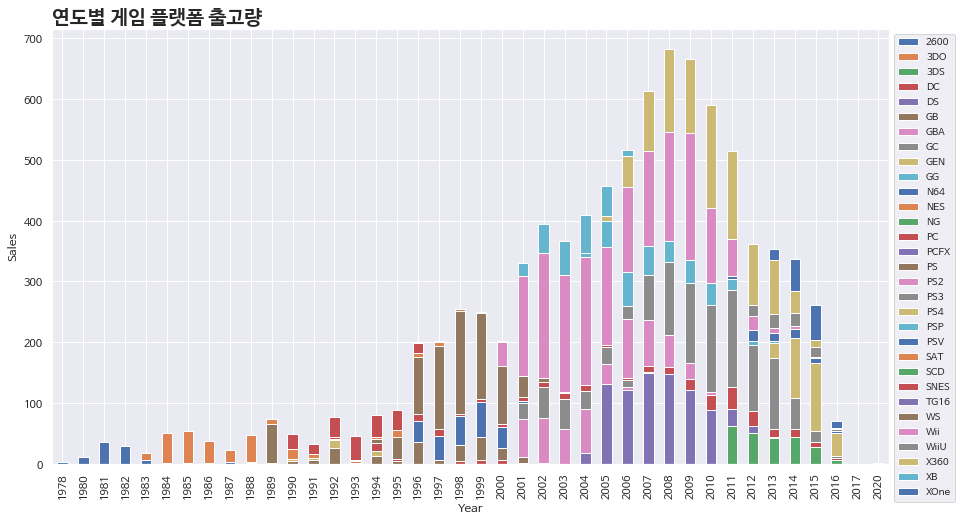

In [ ]:
# multi index 사용 시 stack/ unstack 사용

ax = year_plat_trend['Global_Sales'].unstack().plot.bar(stacked=True, figsize=(15,8))
ax.set_title('연도별 게임 플랫폼 출고량',fontsize=20, fontweight='bold', loc= 'left')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small');

ax.set_ylabel('Sales')
ax.set_xlabel('Year')

plt.show();

###**2-2-5. 연도별 플랫폼 출고량 확인 (2000년대 이후)**


Text(0.0, 1.0, '2000년대 이후 연도별 플랫폼 출고량')

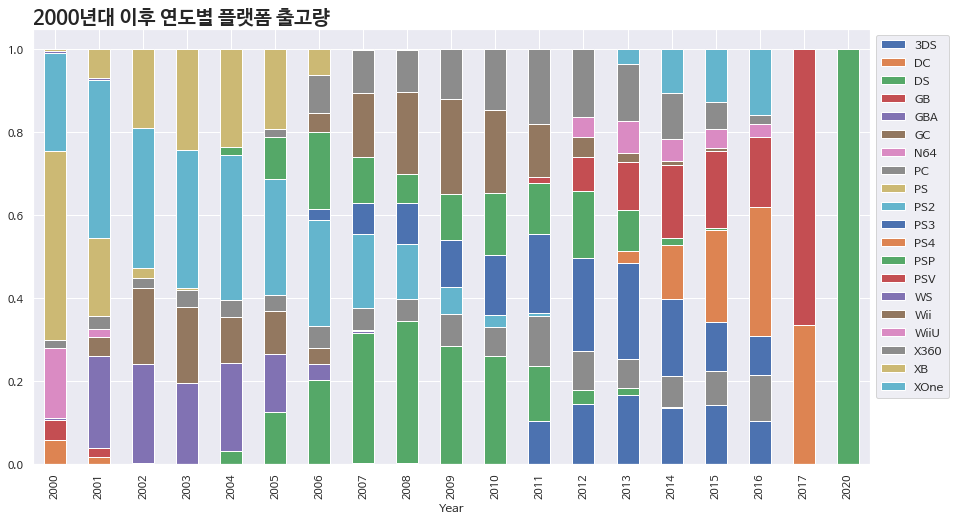

In [ ]:
plt.figure(figsize=(12,4), dpi=100)

year_plat_trend_percent = pd.crosstab(df_2000['Year'],df_2000['Platform']).apply(lambda x : x/x.sum(), axis = 1)
ax = year_plat_trend_percent.plot(kind='bar',stacked=True, figsize=(15,8))

ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='medium')
ax.set_title("2000년대 이후 연도별 플랫폼 출고량",loc='left', fontweight='bold', fontsize=20)

- **연도별 장르**<br>
  시간이 지나도 인기있는 게임 장르(=출고량이 높은 게임 장르)는 어느 정도 유지되고 있음을 알 수 있다.<br>
  (cf. 2017년 ~ 2020년 데이터는 게임 시장 내 모바일 게임의 강세로 비디오 게임 출고량이 줄어듦에 따라 데이터가 부족함으로 중요하게 고려하지 않는다.)<br>
  꾸준히 수요가 있어온 게임 장르들 중 하나를 선택하여 다음 분기 게임을 기획하는 것이 좋은 판단이라 생각된다.



- **연도별 플랫폼**<br>
그러나 플랫폼은 시간이 지나면서 출고량 순위가 크게 바뀌는 것을 확인할 수 있다.<br>
또한 게임 장르는 그 카테고리 값에 변동이 없는 것에 비하여, 플랫폼은 시대에 따라 아예 출고되지 않은(=사라진) 플랫폼도 존재한다.<br>
따라서 최근 플랫폼 트랜드를 신경써서 다음 분기에 사라지지 않을 플랫폼을 선택해 다음 게임 상품을 기획해아한다.

##**2-3. 2000년대 이후 출고량이 높은 게임에 대한 분석 및 시각화 프로세스**

In [ ]:
grouped_top20_sales = df_2000.sort_values(by="Global_Sales",ascending=False)[:20]
grouped_top20_sales

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
2908,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
12579,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.83
3352,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
6937,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01
3014,Wii Play,Wii,2006,Misc,Nintendo,14.03,9.20,2.93,2.85,29.01
16531,New Super Mario Bros. Wii,Wii,2009,Platform,Nintendo,14.59,7.06,4.70,2.26,28.61
11137,Nintendogs,DS,2005,Simulation,Nintendo,9.07,11.00,1.93,2.75,24.75
10650,Mario Kart DS,DS,2005,Racing,Nintendo,9.81,7.57,4.13,1.92,23.43
3435,Wii Fit,Wii,2007,Sports,Nintendo,8.94,8.03,3.60,2.15,22.72
10899,Wii Fit Plus,Wii,2009,Sports,Nintendo,9.09,8.59,2.53,1.79,22.00


### **2-3-1. 2000년 이후 전체 출고량 기준 top20**

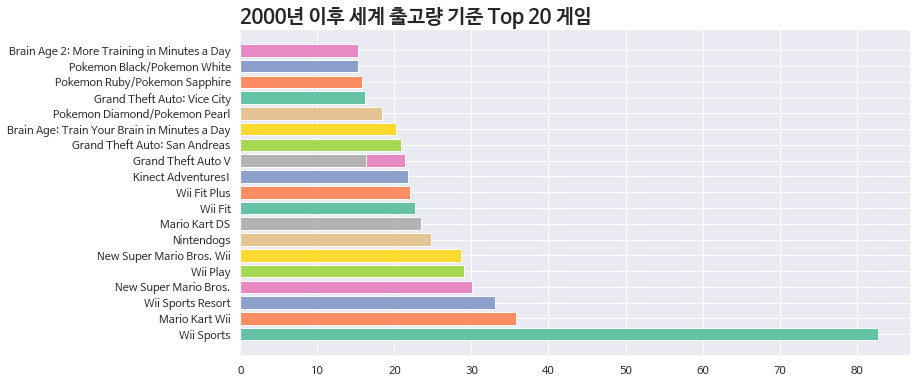

In [ ]:
# 출고량이 가장 많은 상위 20위 게임들
colors = sns.color_palette("Set2")

plt.figure(figsize=(12,6))
plt.barh(grouped_top20_sales.Name ,grouped_top20_sales['Global_Sales'], color=colors)
plt.title(label='2000년 이후 세계 출고량 기준 Top 20 게임', fontsize=20, fontweight='bold', loc = 'left')
plt.show()


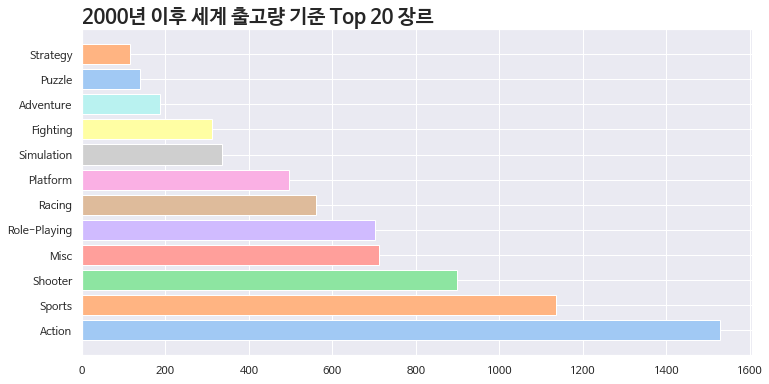

In [ ]:
# 출고량이 가장 많은 상위 20위 게임 장르

colors = sns.color_palette("pastel")


plt.figure(figsize = (12,6))

grouped_top20_genre = df_2000.groupby(["Genre"])[["Global_Sales"]].sum()
top20_genre = grouped_top20_genre.sort_values(by='Global_Sales',ascending=False)[:20]

plt.barh(top20_genre.index ,top20_genre['Global_Sales'],color=colors)
plt.title(label='2000년 이후 세계 출고량 기준 Top 20 장르', fontsize= 20, fontweight='bold',loc='left')
plt.show()

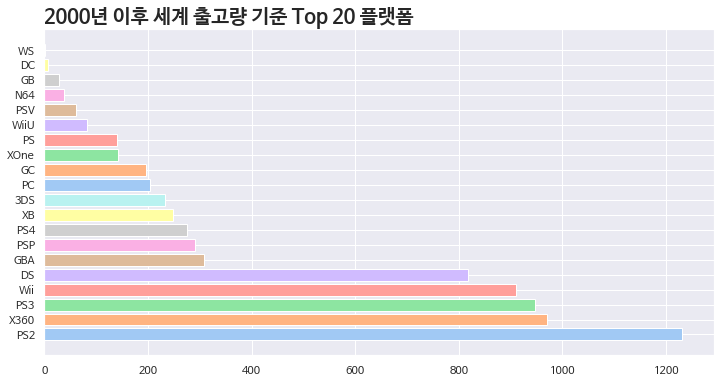

In [ ]:
# 출고량이 가장 많은 상위 20위 게임 플랫폼

colors = sns.color_palette("pastel")


plt.figure(figsize = (12,6))

grouped_top20_platform = df_2000.groupby(["Platform"])[["Global_Sales"]].sum()
top20_platform = grouped_top20_platform.sort_values(by='Global_Sales',ascending=False)[:20]

plt.barh(top20_platform.index ,top20_platform['Global_Sales'],color=colors)
plt.title(label='2000년 이후 세계 출고량 기준 Top 20 플랫폼', fontsize= 20, fontweight='bold',loc='left')
plt.show()

### **2-3-2. 2010년 이후 전체 출고량 기준 top20**

In [ ]:
df_2010 = df[df['Year']>=2010]
grouped_top20_sales_2010 = df_2010.sort_values(by="Global_Sales",ascending=False)[:10]
grouped_top20_sales_2010

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
4343,Kinect Adventures!,X360,2010,Misc,Microsoft Game Studios,14.97,4.94,0.24,1.67,21.82
3483,Grand Theft Auto V,PS3,2013,Action,Take-Two Interactive,7.01,9.27,0.97,4.14,21.39
10913,Grand Theft Auto V,X360,2013,Action,Take-Two Interactive,9.63,5.31,0.06,1.38,16.38
10621,Pokemon Black/Pokemon White,DS,2010,Role-Playing,Nintendo,5.57,3.28,5.65,0.82,15.32
2809,Call of Duty: Modern Warfare 3,X360,2011,Shooter,Activision,9.03,4.28,0.13,1.32,14.76
6248,Call of Duty: Black Ops,X360,2010,Shooter,Activision,9.67,3.73,0.11,1.13,14.64
9070,Call of Duty: Black Ops 3,PS4,2015,Shooter,Activision,5.77,5.81,0.35,2.31,14.24
4240,Call of Duty: Black Ops II,PS3,2012,Shooter,Activision,4.99,5.88,0.65,2.52,14.04
6393,Call of Duty: Black Ops II,X360,2012,Shooter,Activision,8.25,4.30,0.07,1.12,13.74
14120,Call of Duty: Modern Warfare 3,PS3,2011,Shooter,Activision,5.54,5.82,0.49,1.62,13.47


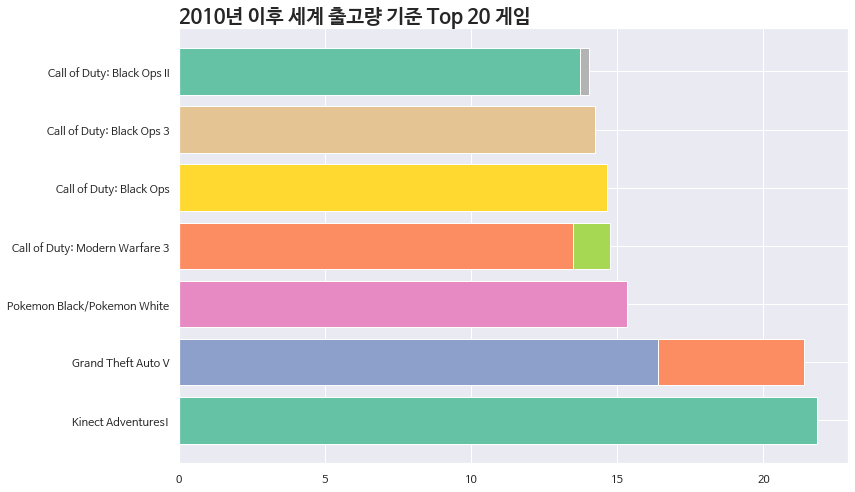

In [ ]:
# 출고량이 가장 많은 상위 20위 게임들

colors = sns.color_palette("Set2")

plt.figure(figsize=(12,8))
plt.barh(grouped_top20_sales_2010['Name'],grouped_top20_sales_2010['Global_Sales'], color=colors)
plt.title(label='2010년 이후 세계 출고량 기준 Top 20 게임', fontsize=20, fontweight='bold', loc = 'left')
plt.show()


In [ ]:
grouped_top20_sales_2010

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
4343,Kinect Adventures!,X360,2010,Misc,Microsoft Game Studios,14.97,4.94,0.24,1.67,21.82
3483,Grand Theft Auto V,PS3,2013,Action,Take-Two Interactive,7.01,9.27,0.97,4.14,21.39
10913,Grand Theft Auto V,X360,2013,Action,Take-Two Interactive,9.63,5.31,0.06,1.38,16.38
10621,Pokemon Black/Pokemon White,DS,2010,Role-Playing,Nintendo,5.57,3.28,5.65,0.82,15.32
2809,Call of Duty: Modern Warfare 3,X360,2011,Shooter,Activision,9.03,4.28,0.13,1.32,14.76
6248,Call of Duty: Black Ops,X360,2010,Shooter,Activision,9.67,3.73,0.11,1.13,14.64
9070,Call of Duty: Black Ops 3,PS4,2015,Shooter,Activision,5.77,5.81,0.35,2.31,14.24
4240,Call of Duty: Black Ops II,PS3,2012,Shooter,Activision,4.99,5.88,0.65,2.52,14.04
6393,Call of Duty: Black Ops II,X360,2012,Shooter,Activision,8.25,4.30,0.07,1.12,13.74
14120,Call of Duty: Modern Warfare 3,PS3,2011,Shooter,Activision,5.54,5.82,0.49,1.62,13.47


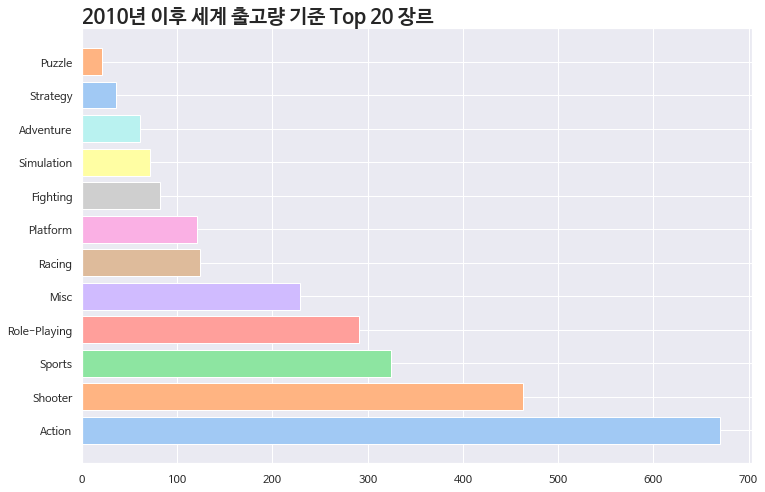

In [ ]:
# 출고량이 가장 많은 상위 20위 게임 장르

colors = sns.color_palette("pastel")

plt.figure(figsize = (12,8))

grouped_top20_genre_2010 = df_2010.groupby(["Genre"])[["Global_Sales"]].sum()
top20_genre_2010 = grouped_top20_genre_2010.sort_values(by='Global_Sales',ascending=False)[:20]

plt.barh(top20_genre_2010.index ,top20_genre_2010['Global_Sales'],color=colors)
plt.title(label='2010년 이후 세계 출고량 기준 Top 20 장르', fontsize= 20, fontweight='bold',loc='left')
plt.show()

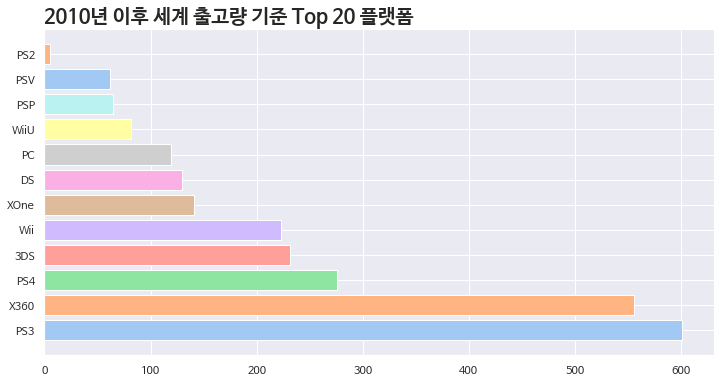

In [ ]:
# 출고량이 가장 많은 상위 20위 게임 플랫폼

colors = sns.color_palette("pastel")


plt.figure(figsize = (12,6))

grouped_top20_platform_2010 = df_2010.groupby(["Platform"])[["Global_Sales"]].sum()
top20_platform_2010 = grouped_top20_platform_2010.sort_values(by='Global_Sales',ascending=False)[:20]

plt.barh(top20_platform_2010.index ,top20_platform_2010['Global_Sales'],color=colors)
plt.title(label='2010년 이후 세계 출고량 기준 Top 20 플랫폼', fontsize= 20, fontweight='bold',loc='left')
plt.show()

### **2-3-3. 지역별 출고량 기준 게임 top10 in 2000s**

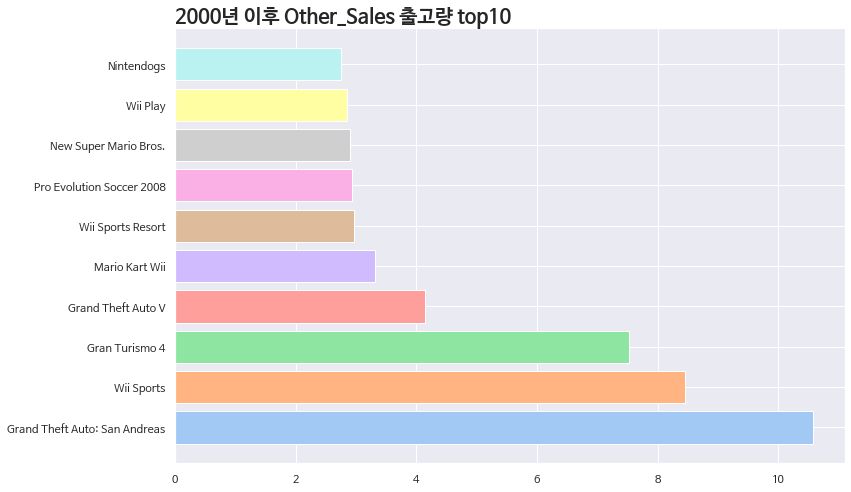

In [ ]:
# other_sales기준 게임 top 10 in 2000s
plt.figure(figsize = (12, 8))

cond1 = (df['Year'] >= 2000)
other_trend_game = df[cond1].sort_values(by="Other_Sales",ascending=False).head(10)
other_trend_game

plt.barh(other_trend_game.Name ,other_trend_game['Other_Sales'],color=colors)
plt.title(label='2000년 이후 Other_Sales 출고량 top10', fontsize = 20, fontweight='bold',loc='left')
plt.show()

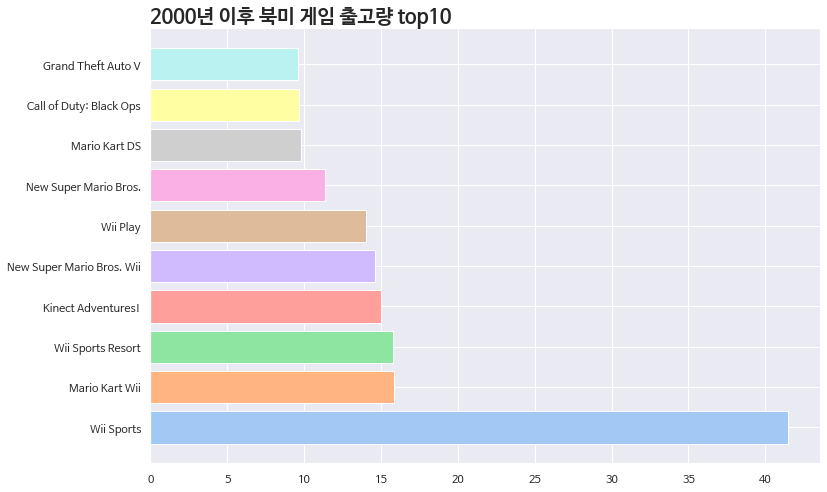

In [ ]:
# NA_sales기준 게임 top 10 in 2000s
plt.figure(figsize=(12,8))
cond1 = (df['Year'] >= 2000)
na_trend_game = df[cond1].sort_values(by="NA_Sales",ascending=False).head(10)

plt.barh(na_trend_game.Name ,na_trend_game['NA_Sales'],color=colors)
plt.title(label='2000년 이후 북미 게임 출고량 top10', fontsize = 20, fontweight='bold',loc='left')
plt.show()

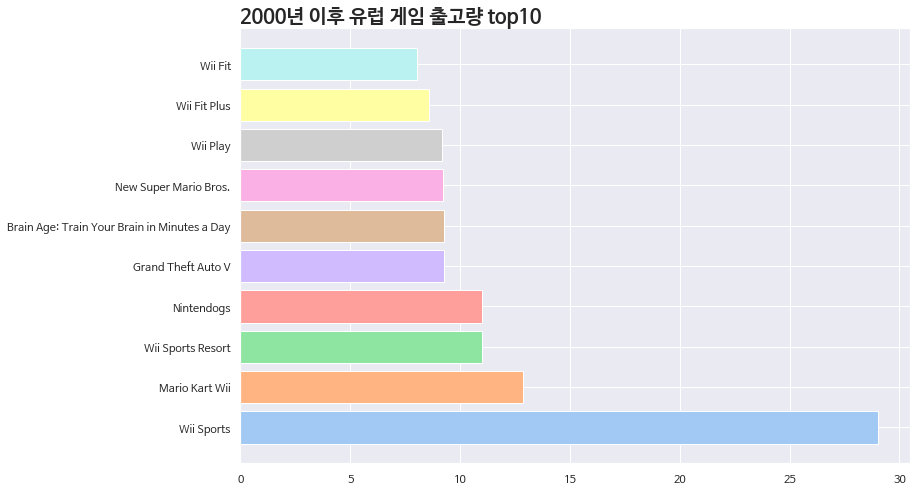

In [ ]:
# EU_sales기준 게임 트랜드
plt.figure(figsize=(12,8))

cond1 = (df['Year'] >= 2000)
EU_trend_game = df[cond1].sort_values(by="EU_Sales",ascending=False).head(10)
other_trend_game

plt.barh(EU_trend_game.Name ,EU_trend_game['EU_Sales'],color=colors)
plt.title(label='2000년 이후 유럽 게임 출고량 top10', fontsize = 20, fontweight='bold',loc='left')
plt.show()

In [ ]:
EU_trend_game.sort_values('EU_Sales')

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
6216,Gran Turismo 5,PS3,2010,Racing,Sony Computer Entertainment,2.96,4.88,0.81,2.12,10.77
4343,Kinect Adventures!,X360,2010,Misc,Microsoft Game Studios,14.97,4.94,0.24,1.67,21.82
9035,FIFA Soccer 13,PS3,2012,Action,Electronic Arts,1.06,5.05,0.13,2.01,8.25
10913,Grand Theft Auto V,X360,2013,Action,Take-Two Interactive,9.63,5.31,0.06,1.38,16.38
2008,Grand Theft Auto V,PS4,2014,Action,Take-Two Interactive,3.80,5.81,0.36,2.02,11.99
9070,Call of Duty: Black Ops 3,PS4,2015,Shooter,Activision,5.77,5.81,0.35,2.31,14.24
14120,Call of Duty: Modern Warfare 3,PS3,2011,Shooter,Activision,5.54,5.82,0.49,1.62,13.47
4240,Call of Duty: Black Ops II,PS3,2012,Shooter,Activision,4.99,5.88,0.65,2.52,14.04
2639,FIFA 16,PS4,2015,Sports,Electronic Arts,1.11,6.06,0.06,1.26,8.49
3483,Grand Theft Auto V,PS3,2013,Action,Take-Two Interactive,7.01,9.27,0.97,4.14,21.39


In [ ]:
cond1 = (df['Year'] >= 2010)
EU_trend_game = df[cond1].sort_values("EU_Sales",ascending=False)[:10]
EU_trend_game

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
3483,Grand Theft Auto V,PS3,2013,Action,Take-Two Interactive,7.01,9.27,0.97,4.14,21.39
2639,FIFA 16,PS4,2015,Sports,Electronic Arts,1.11,6.06,0.06,1.26,8.49
4240,Call of Duty: Black Ops II,PS3,2012,Shooter,Activision,4.99,5.88,0.65,2.52,14.04
14120,Call of Duty: Modern Warfare 3,PS3,2011,Shooter,Activision,5.54,5.82,0.49,1.62,13.47
2008,Grand Theft Auto V,PS4,2014,Action,Take-Two Interactive,3.80,5.81,0.36,2.02,11.99
9070,Call of Duty: Black Ops 3,PS4,2015,Shooter,Activision,5.77,5.81,0.35,2.31,14.24
10913,Grand Theft Auto V,X360,2013,Action,Take-Two Interactive,9.63,5.31,0.06,1.38,16.38
9035,FIFA Soccer 13,PS3,2012,Action,Electronic Arts,1.06,5.05,0.13,2.01,8.25
4343,Kinect Adventures!,X360,2010,Misc,Microsoft Game Studios,14.97,4.94,0.24,1.67,21.82
6216,Gran Turismo 5,PS3,2010,Racing,Sony Computer Entertainment,2.96,4.88,0.81,2.12,10.77


<Figure size 864x720 with 0 Axes>

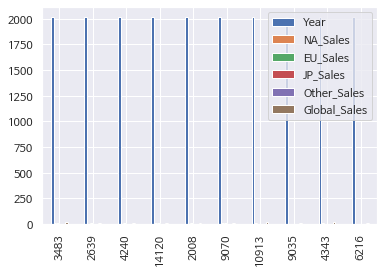

In [ ]:
# EU_sales기준 게임 트랜드
plt.figure(figsize=(12,10))

colors = sns.color_palette("pastel")
cond1 = (df['Year'] >= 2010)
EU_trend_game = df[cond1].sort_values(by="EU_Sales",ascending=False)[:10]
EU_trend_game.plot.bar()

# plt.barh(EU_trend_game.Name ,EU_trend_game['EU_Sales'], color = colors)
# plt.title(label='2010년 이후 유럽 게임 출고량 top10', fontsize = 20, fontweight='bold',loc='left')
# plt.show()

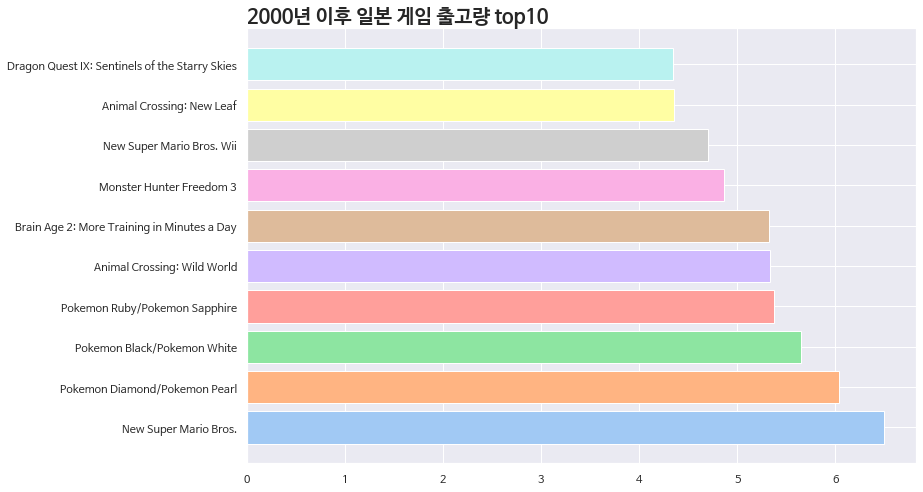

In [ ]:
# JP_sales기준 게임 트랜드
plt.figure(figsize=(12,8))

cond1 = (df['Year'] >= 2000)
jp_trend_game = df[cond1].sort_values(by="JP_Sales",ascending=False).head(10)

plt.barh(jp_trend_game.Name ,jp_trend_game['JP_Sales'],color=colors)
plt.title(label='2000년 이후 일본 게임 출고량 top10', fontsize = 20, fontweight='bold',loc='left')
plt.show()